# オートエンコーダ

# Time Series Anomaly Detection with LSTM Autoencoders using Keras in Python

https://www.youtube.com/watch?v=H4J74KstHTE&t=699s

https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/#lstm-autoencoders

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from keras.models import Model

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

traindata

In [65]:
import pandas as pd

train = pd.read_csv('data/sensor_train_60.csv')
train = train.rename(columns={'4095':'data'})
train.head()

,data
0,4095
1,4095
2,4095
3,4095
4,4095


In [66]:
train = train[1500: 2500]

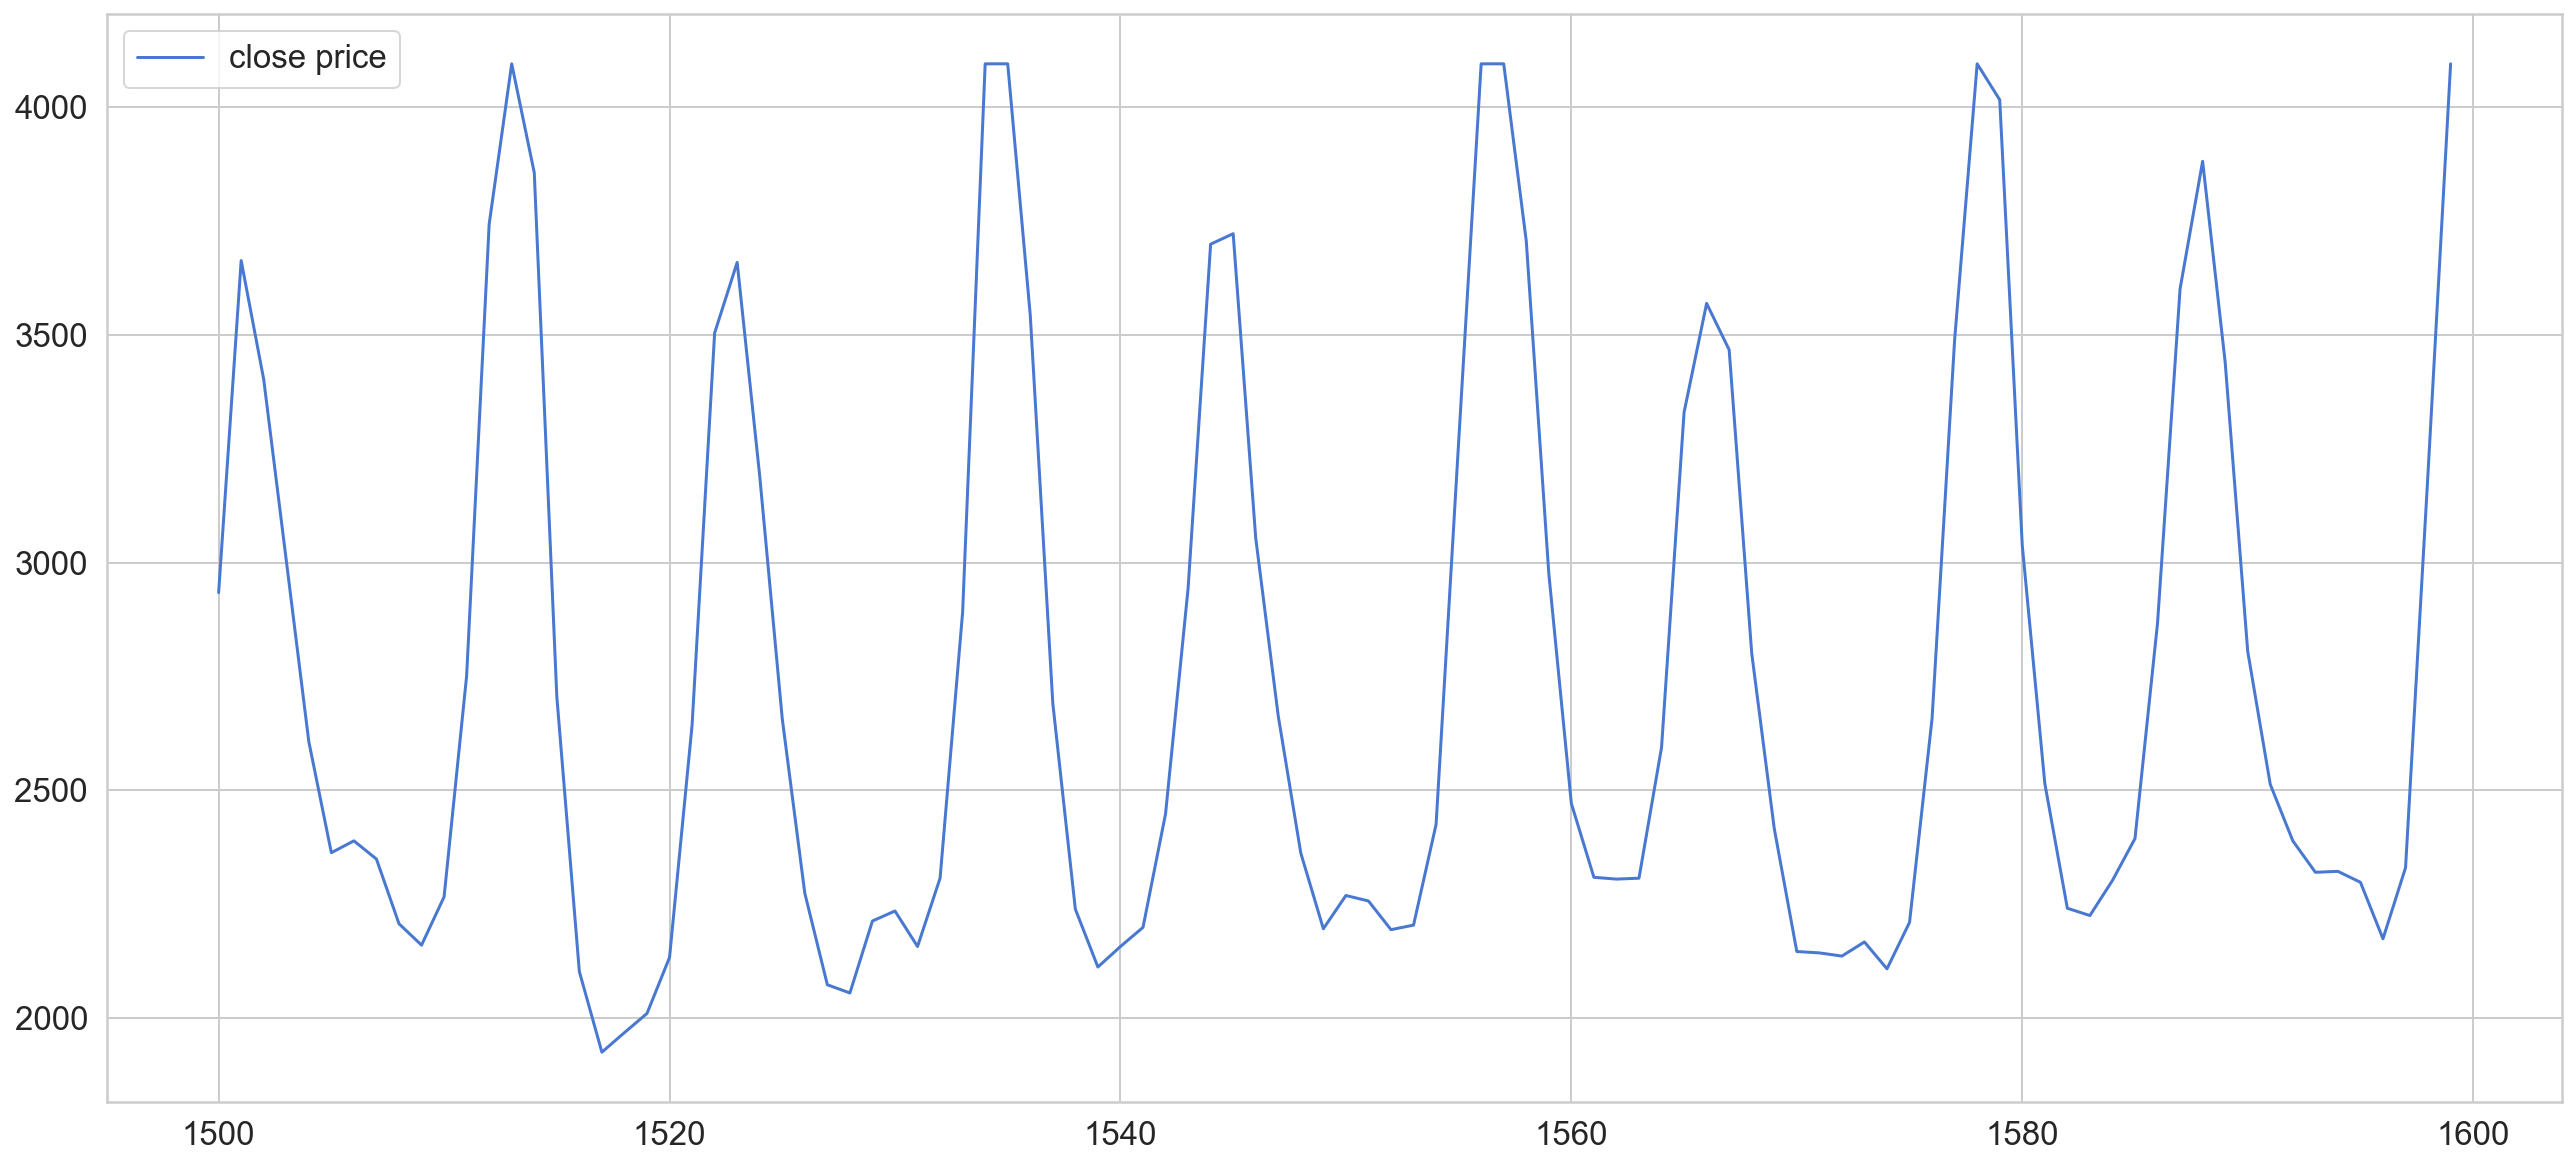

In [67]:
plt.plot(train[0: 100], label='close price')
plt.legend();

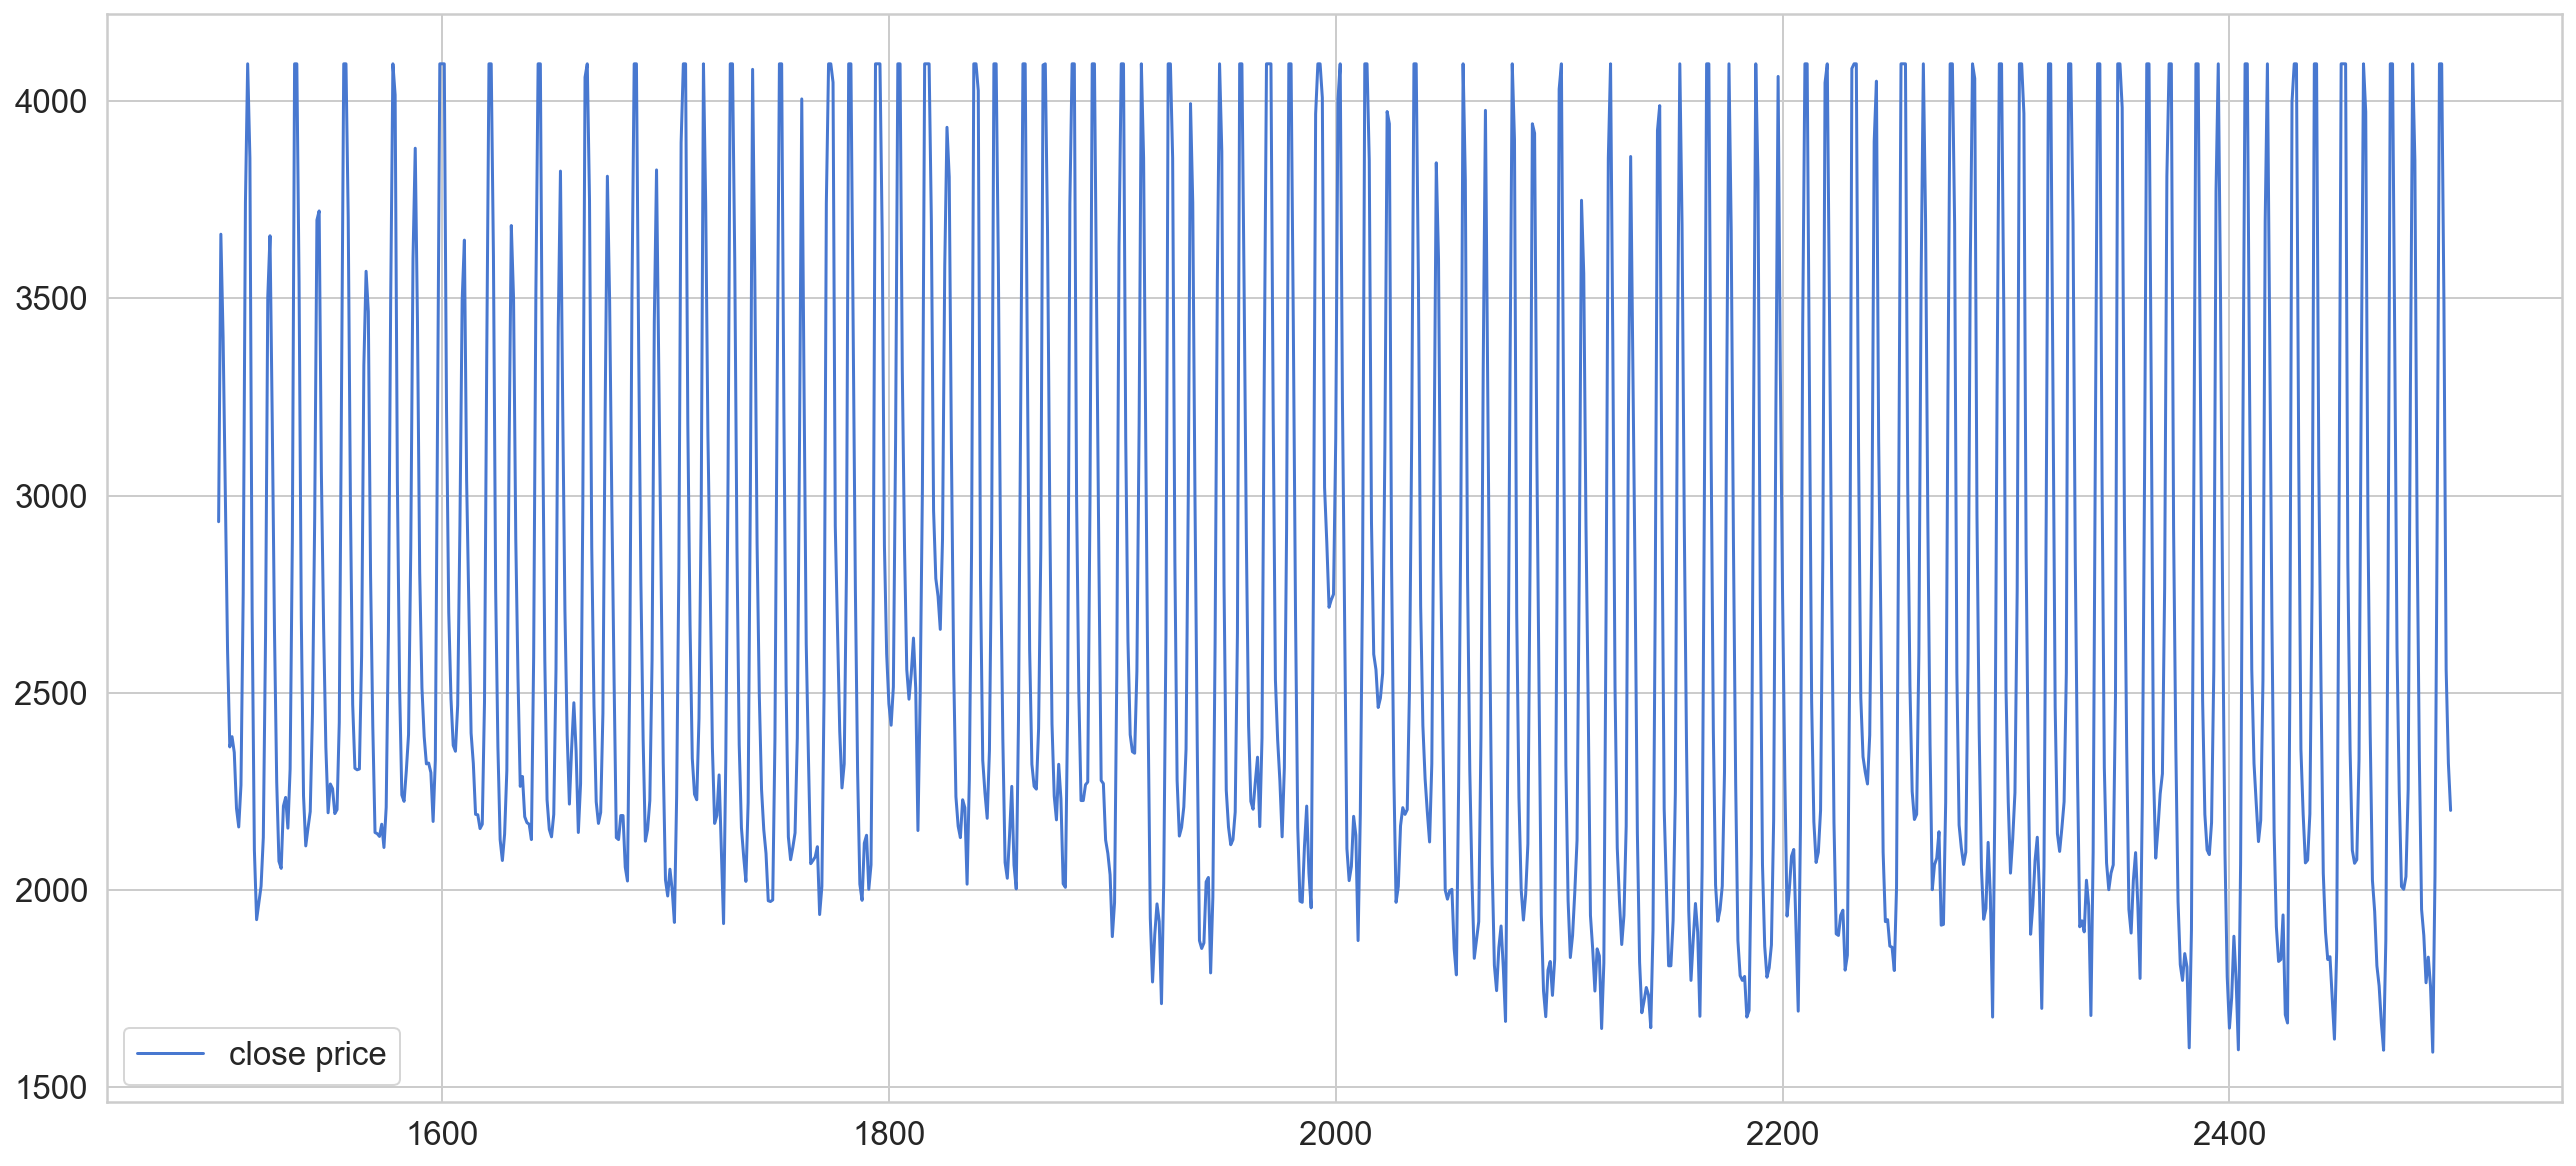

In [68]:
plt.plot(train, label='close price')
plt.legend();

testdata

In [69]:
import pandas as pd

test = pd.read_csv('data/sensor_test1.csv')
test = test.rename(columns={'3636':'data'})
test.head()

,data
0,3649
1,3666
2,3671
3,3698
4,3726


In [70]:
test = test[200: 900]

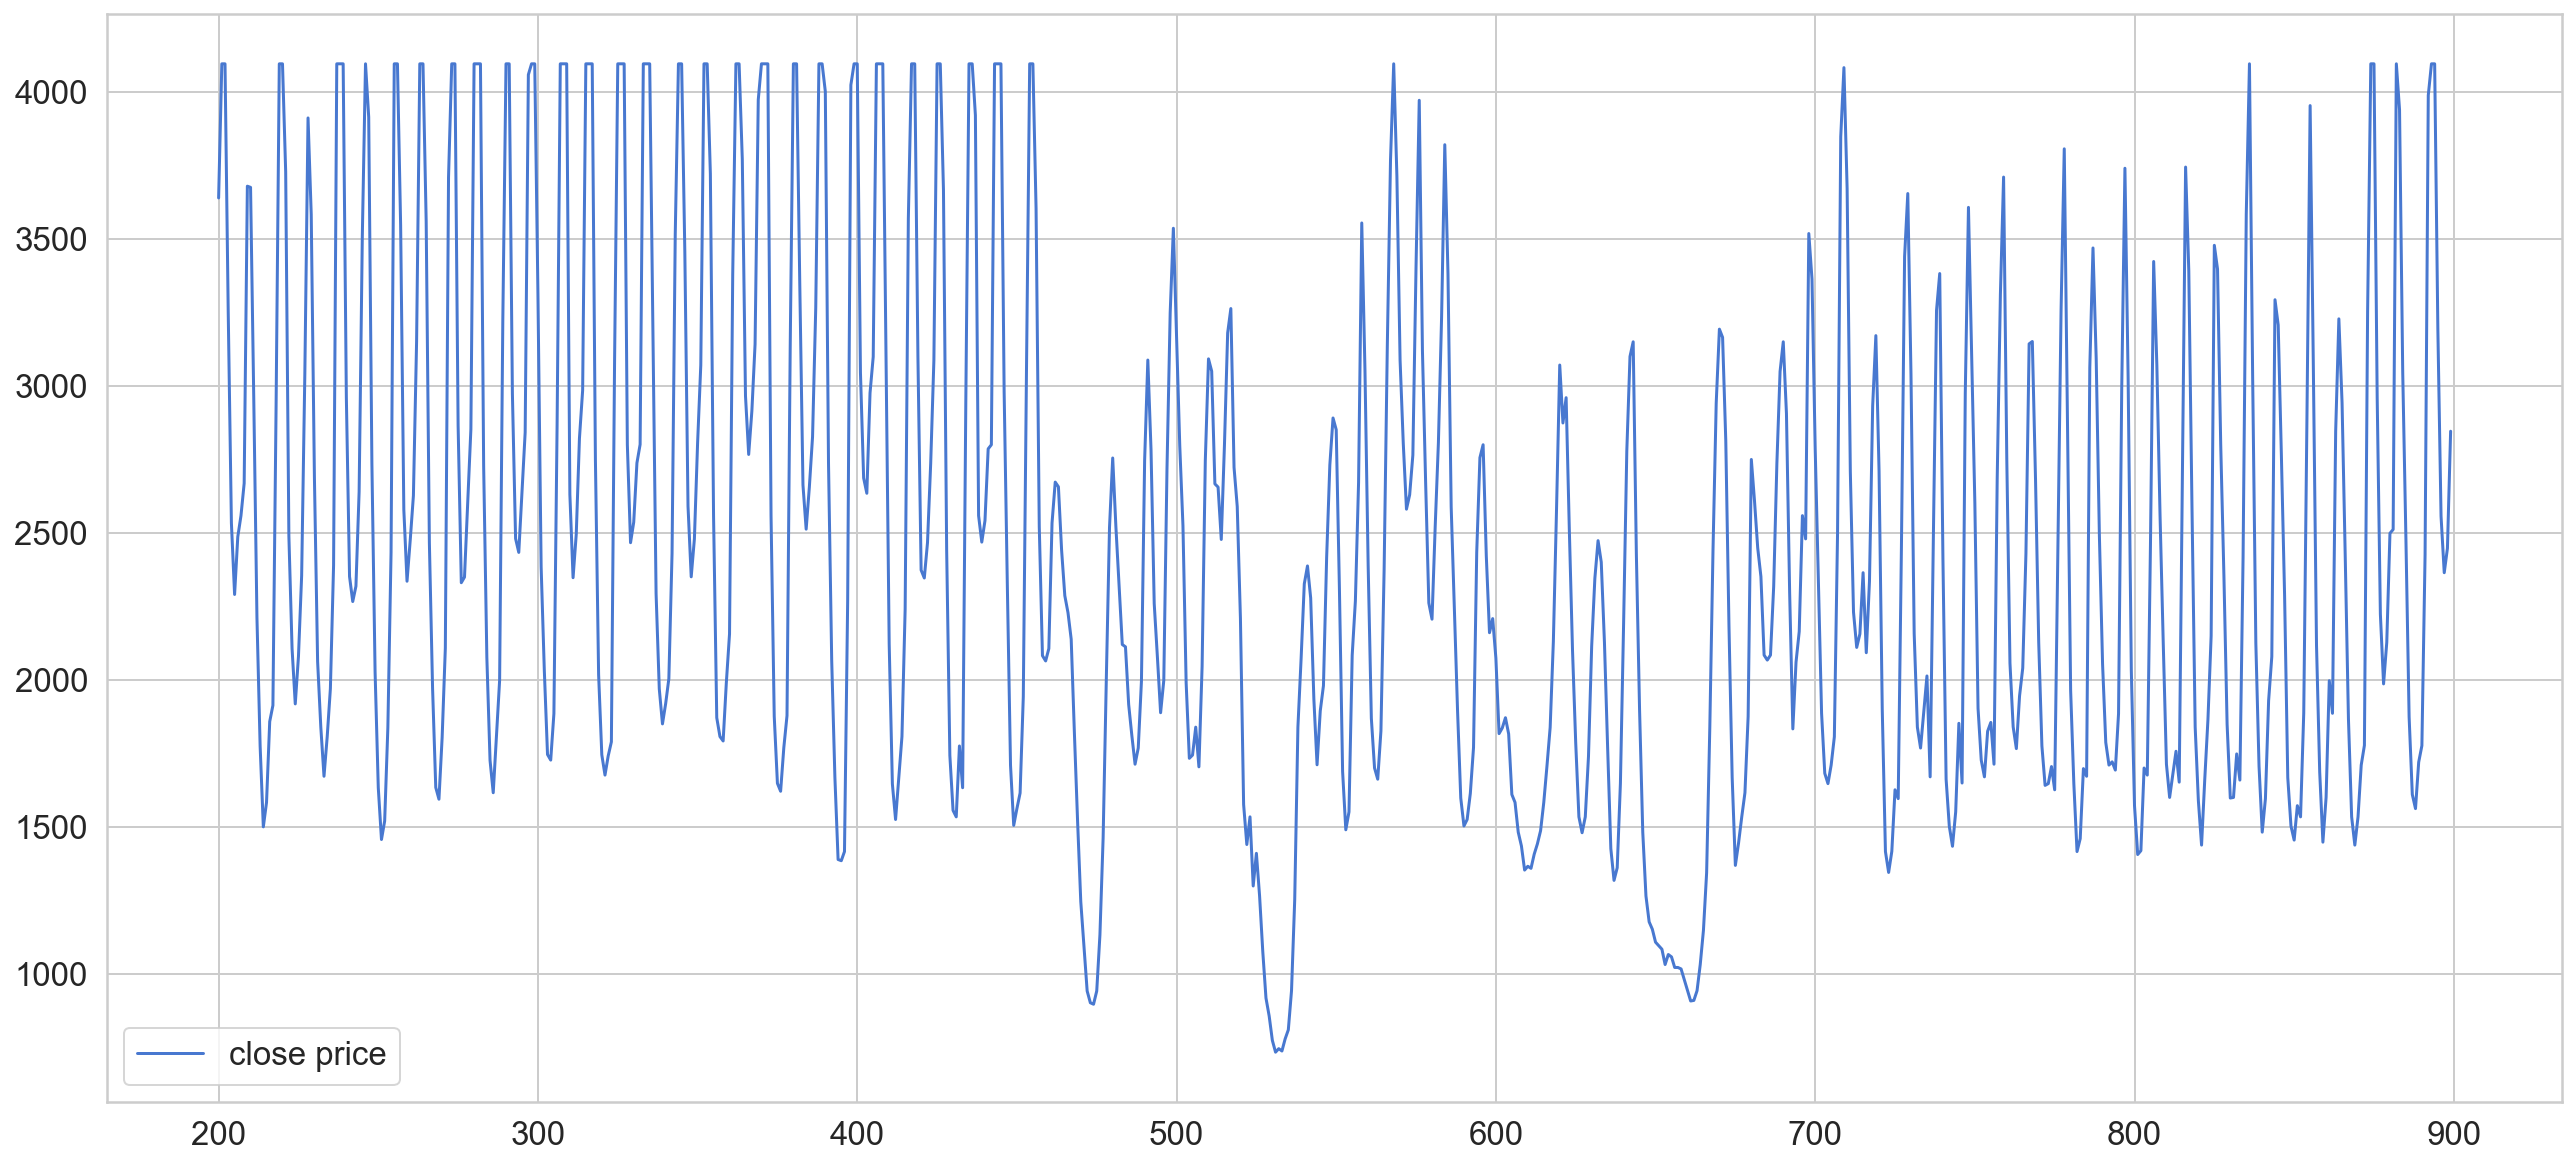

In [71]:
plt.plot(test, label='close price')
plt.legend();

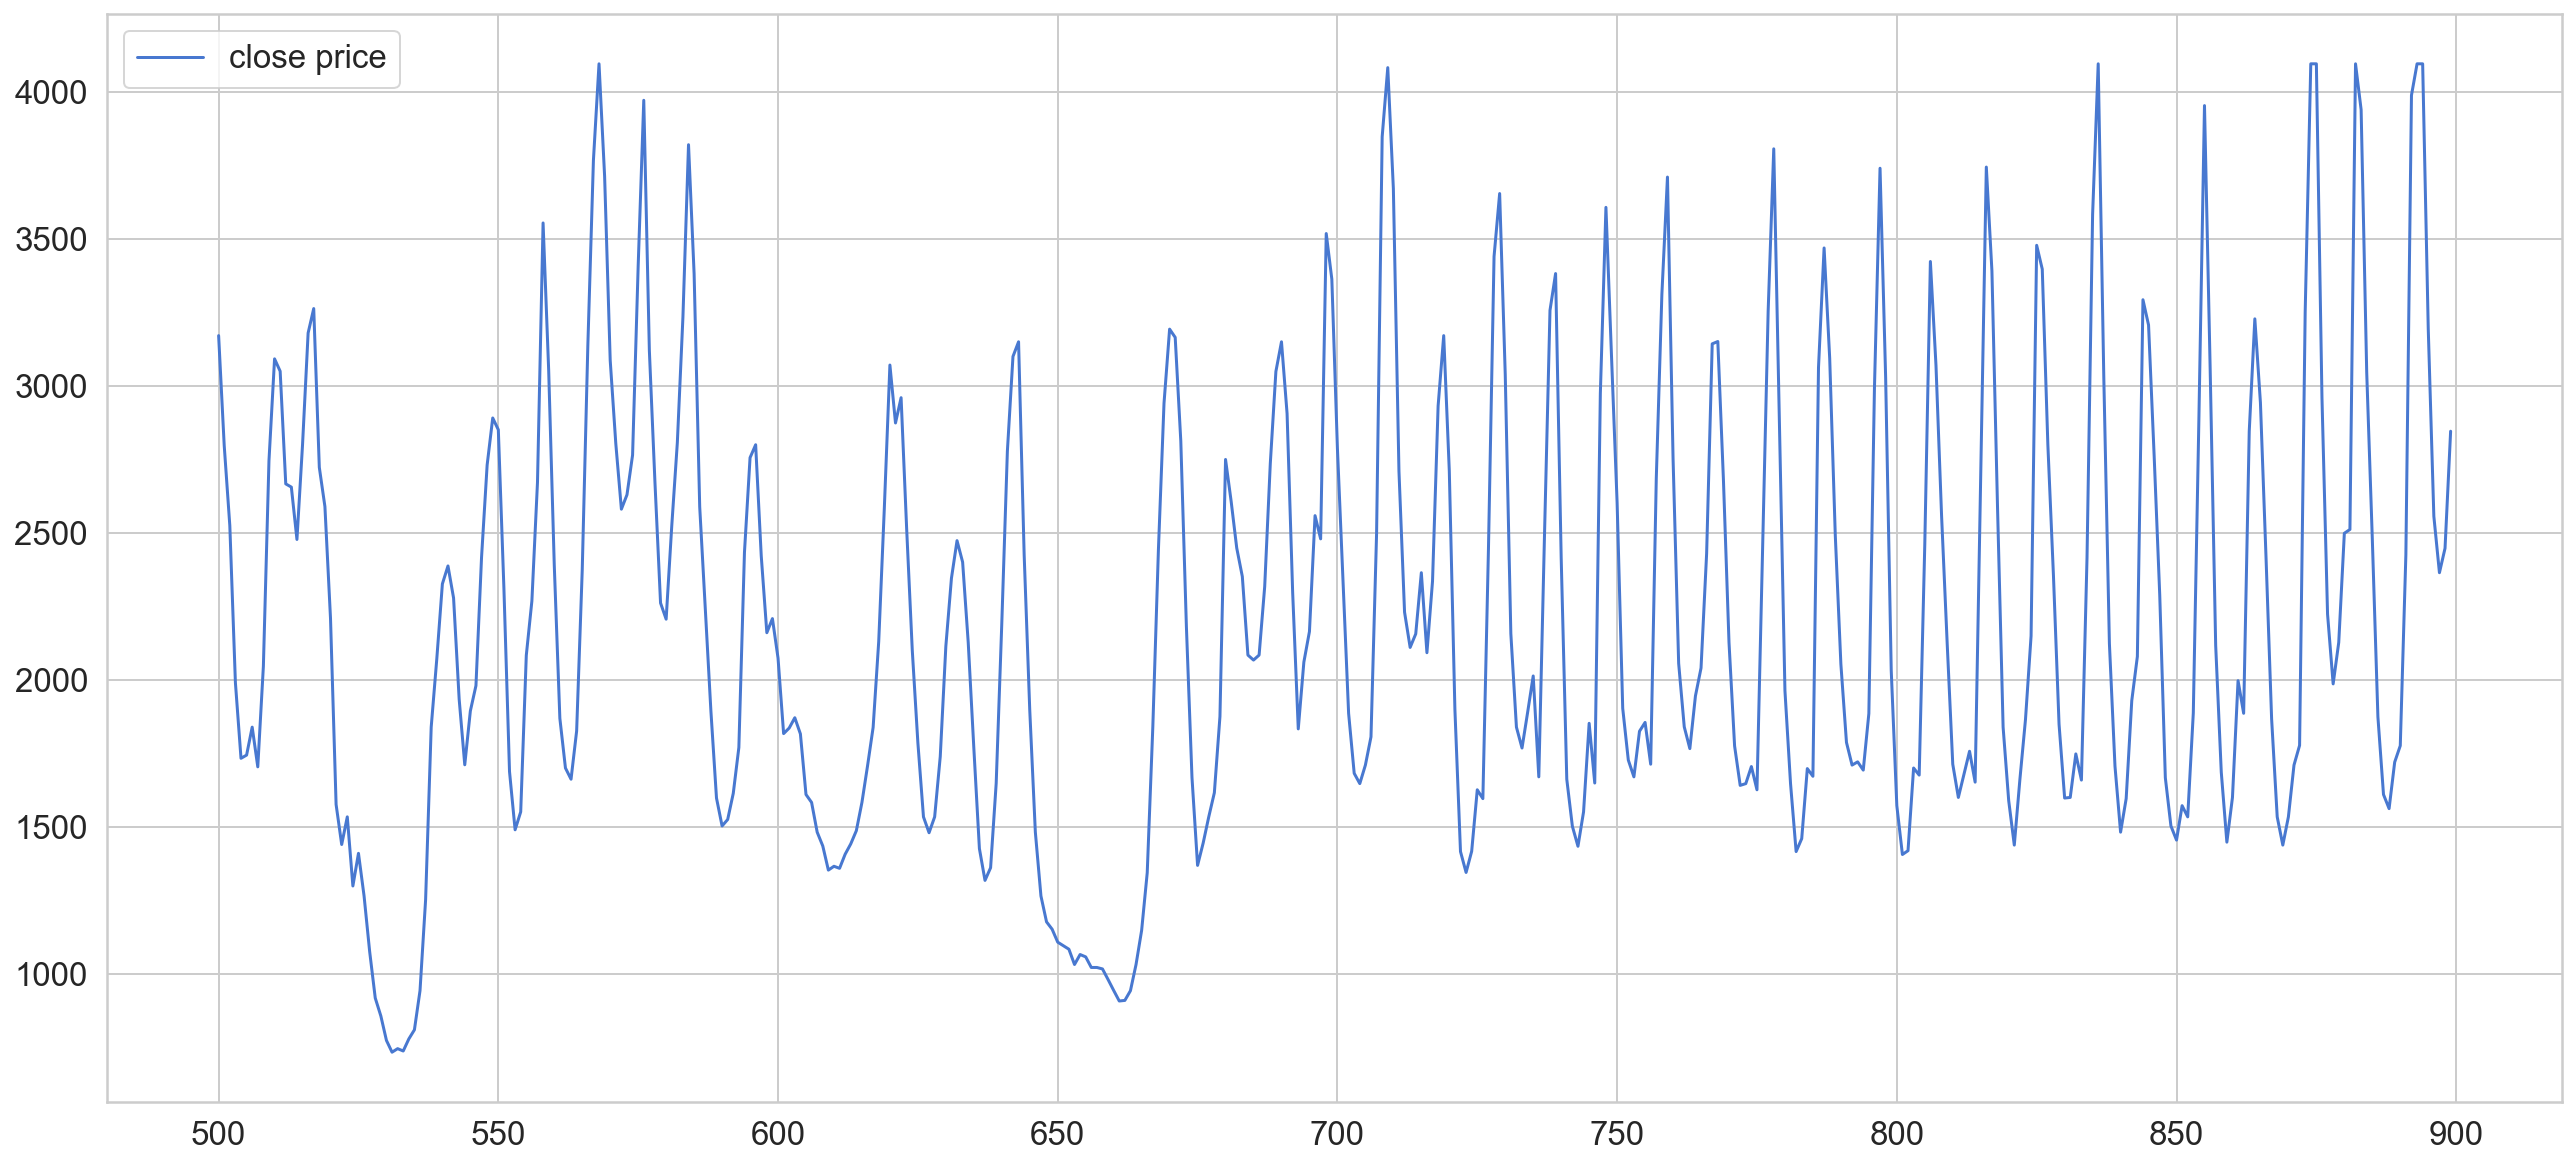

In [74]:
plt.plot(test[300: 900], label='close price')
plt.legend();

In [8]:
train

,data
1500,2934
1501,3663
1502,3402
1503,3005
1504,2607
...,...
2495,4095
2496,3491
2497,2559
2498,2321


## 訓練データとテストデータに分割

train 0~95%目

test 95%~100%

In [9]:
# train_size = int(len(df) * 0.95)
# test_size = len(df) - train_size
# train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
# print(train.shape, test.shape)

## 標準化

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['data']])

train['data'] = scaler.transform(train[['data']])
test['data'] = scaler.transform(test[['data']])

## データセットの作成

30日間のデータから、31日目の値を推定する\
30日間のclose値のが入った配列と、31日目のcloseの値（これが目的の値）のセットを作る

`過去の30日間のデータセット,　31日目のデータ`このセットをいくつも作成

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
train[['data']].iloc[0:30].values

array([[ 0.28921471],
       [ 1.23060075],
       [ 0.89356131],
       [ 0.38089977],
       [-0.1330531 ],
       [-0.44813979],
       [-0.41456498],
       [-0.46621853],
       [-0.64958865],
       [-0.71028158],
       [-0.57339966],
       [ 0.0528997 ],
       [ 1.33390786],
       [ 1.78845915],
       [ 1.47982915],
       [-0.00521055],
       [-0.78517923],
       [-1.01374621],
       [-0.95821864],
       [-0.90398241],
       [-0.74514773],
       [-0.0865649 ],
       [ 1.02527787],
       [ 1.2254354 ],
       [ 0.61979746],
       [-0.06848616],
       [-0.56306895],
       [-0.82262806],
       [-0.84587216],
       [-0.64184062]])

In [13]:
train.data.iloc[31]
# train['close']

-0.7141555950778846

KeyError: 50

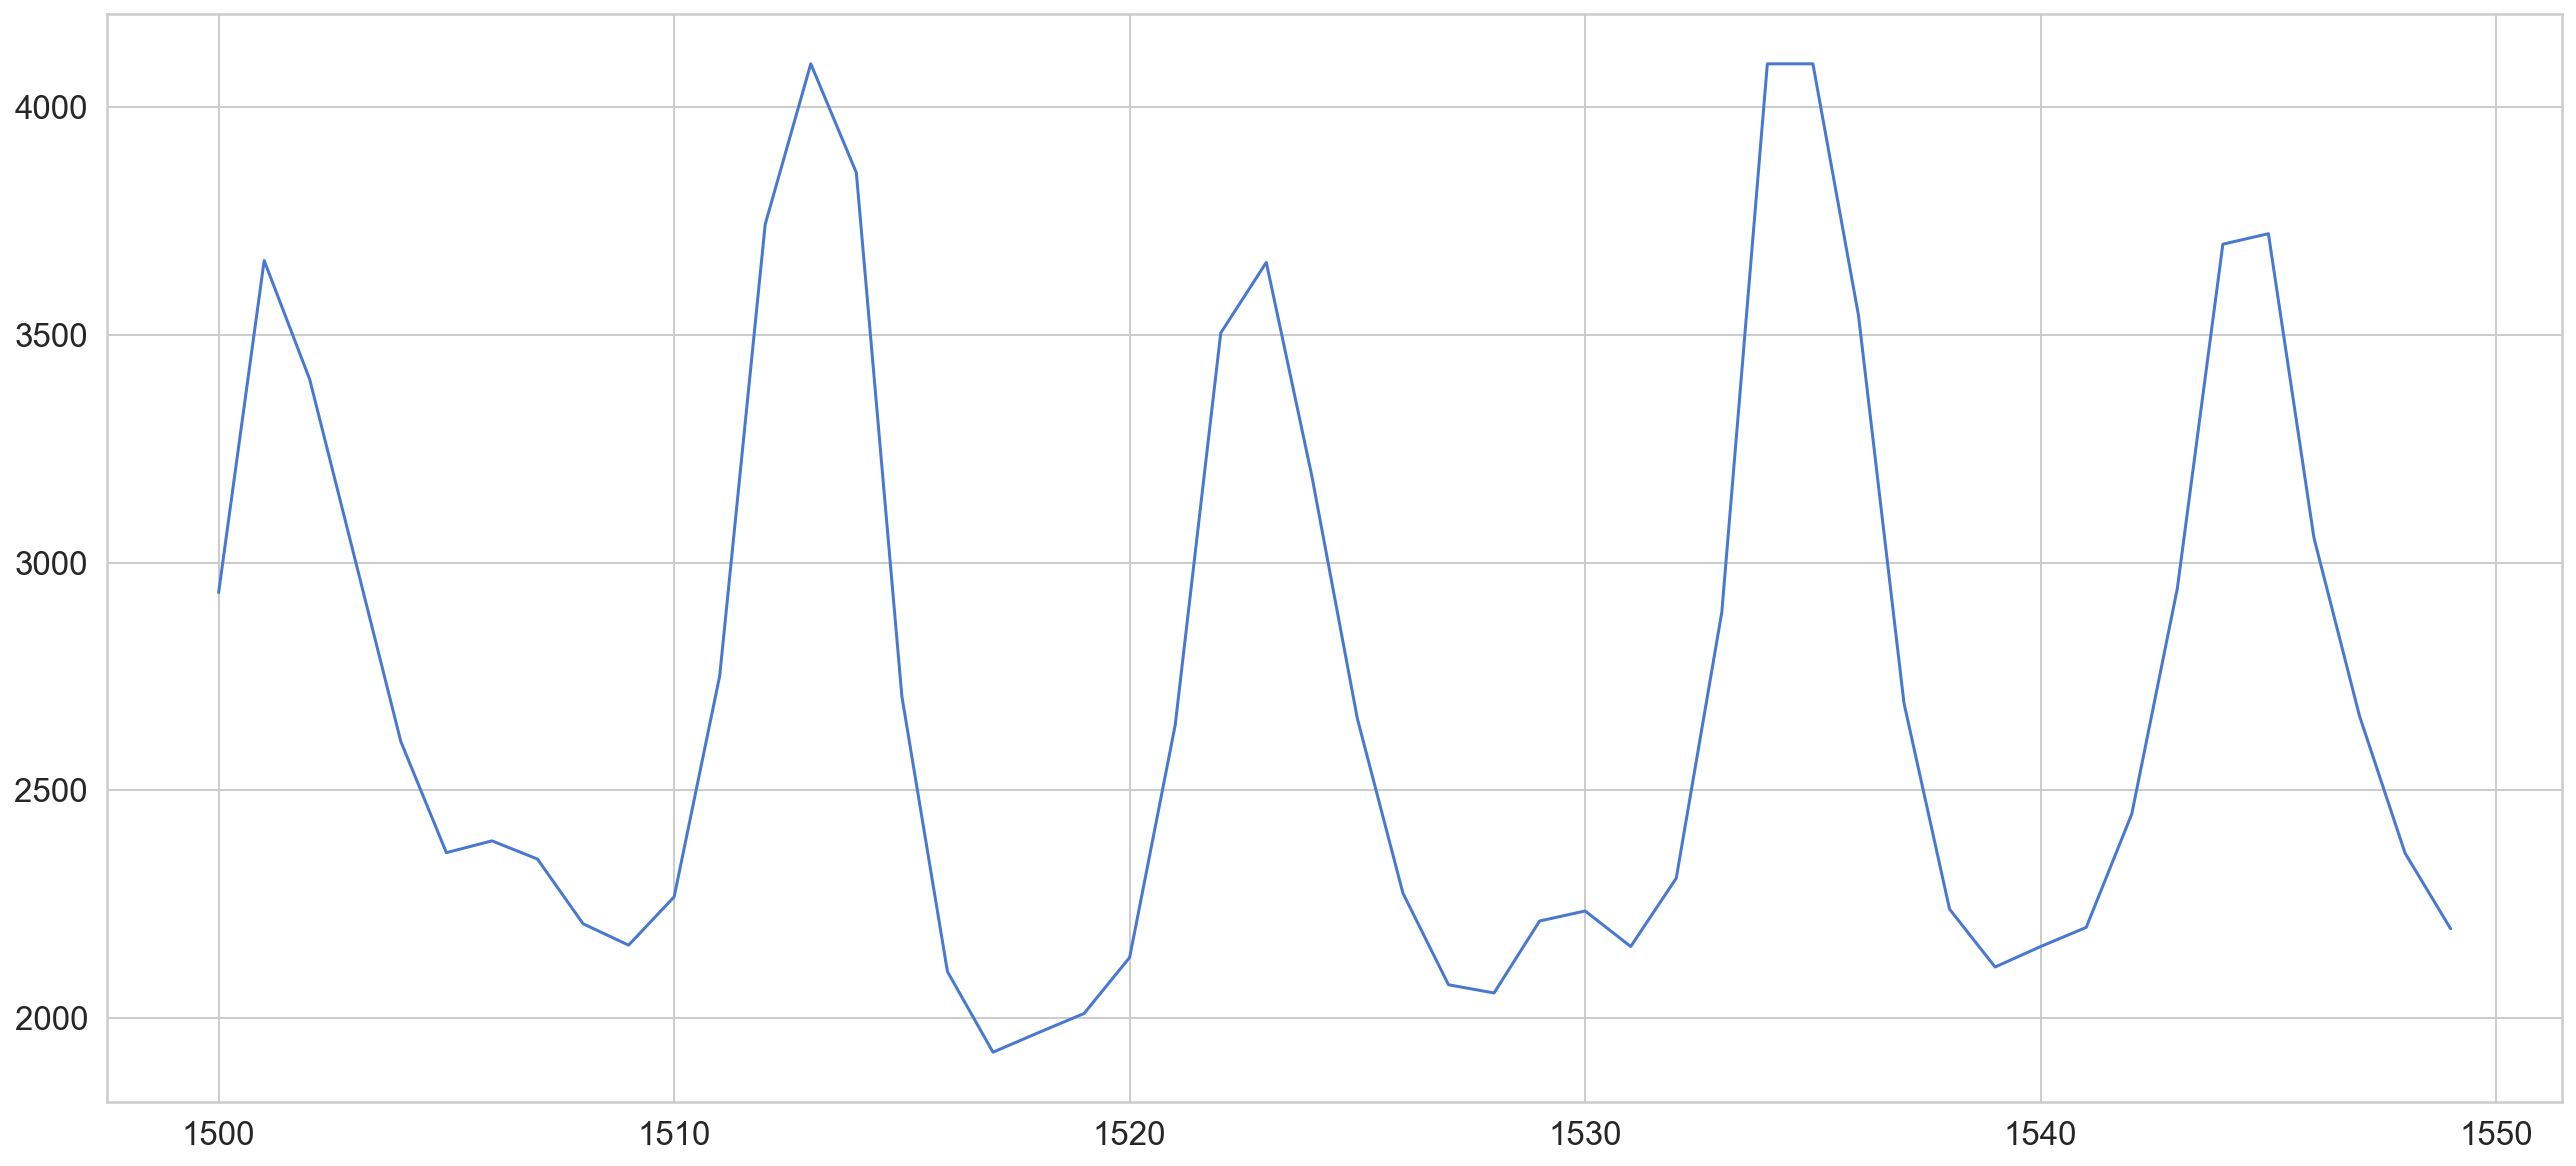

In [78]:
plt.plot(train[0: 50], label='close price')
plt.scatter(train[50], 50, c='r')
plt.legend();

In [83]:
train

,data
1500,2934
1501,3663
1502,3402
1503,3005
1504,2607
...,...
2495,4095
2496,3491
2497,2559
2498,2321


### データセット作成

In [51]:
TIME_STEPS = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['data']], train.data, TIME_STEPS)
X_test, y_test = create_dataset(test[['data']], test.data, TIME_STEPS)

print(X_train.shape)
print(y_train.shape)
print(train.shape)
print(X_train.shape[1])
print(X_train.shape[2])

(950, 50, 1)
(950,)
(1000, 1)
50
1


### モデルの作成

In [52]:
model = keras.Sequential()
#LSTMレイヤの作成、ユニットとインプットのシェイプを確定
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
#正規化
model.add(keras.layers.Dropout(rate=0.2))
#コピー？
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 50, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

### モデルの学習

In [53]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
27/27 [==============================] - 2s 62ms/step - loss: 0.6746 - val_loss: 0.5603
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.4983 - val_loss: 0.4144
Epoch 3/10
27/27 [==============================] - 1s 33ms/step - loss: 0.3951 - val_loss: 0.3140
Epoch 4/10
27/27 [==============================] - 1s 33ms/step - loss: 0.3416 - val_loss: 0.2636
Epoch 5/10
27/27 [==============================] - 1s 33ms/step - loss: 0.3163 - val_loss: 0.2574
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2994 - val_loss: 0.2288
Epoch 7/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2860 - val_loss: 0.2222
Epoch 8/10
27/27 [==============================] - 1s 30ms/step - loss: 0.2729 - val_loss: 0.2113
Epoch 9/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2550 - val_loss: 0.2008
Epoch 10/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2505 - val_loss: 0.1972


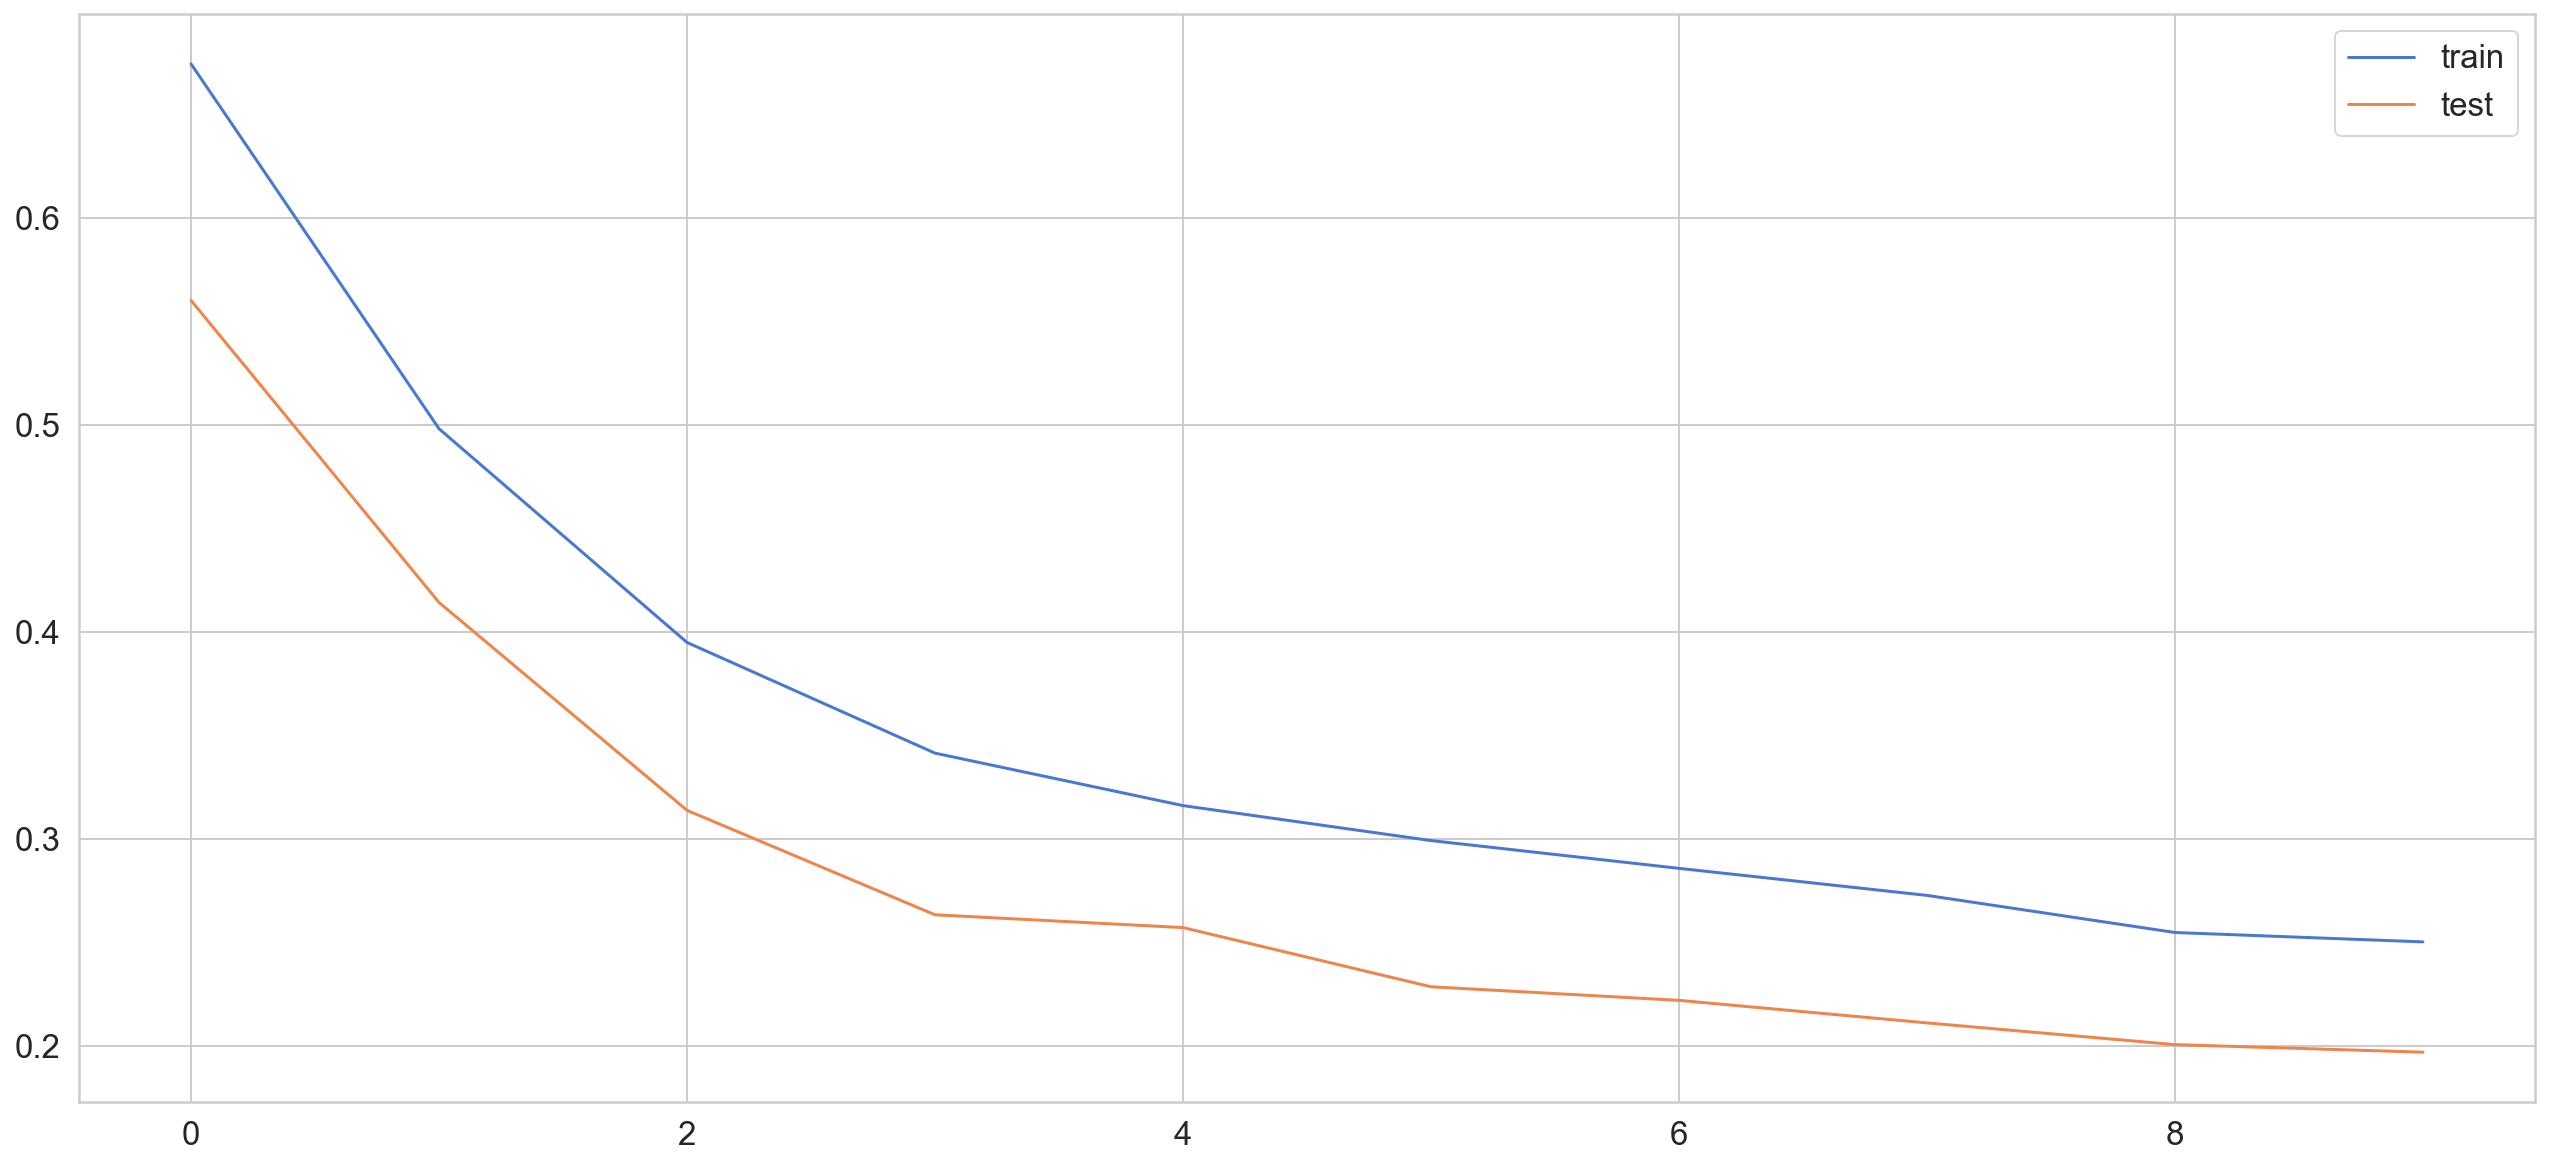

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### 推定誤差を比べる

In [55]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

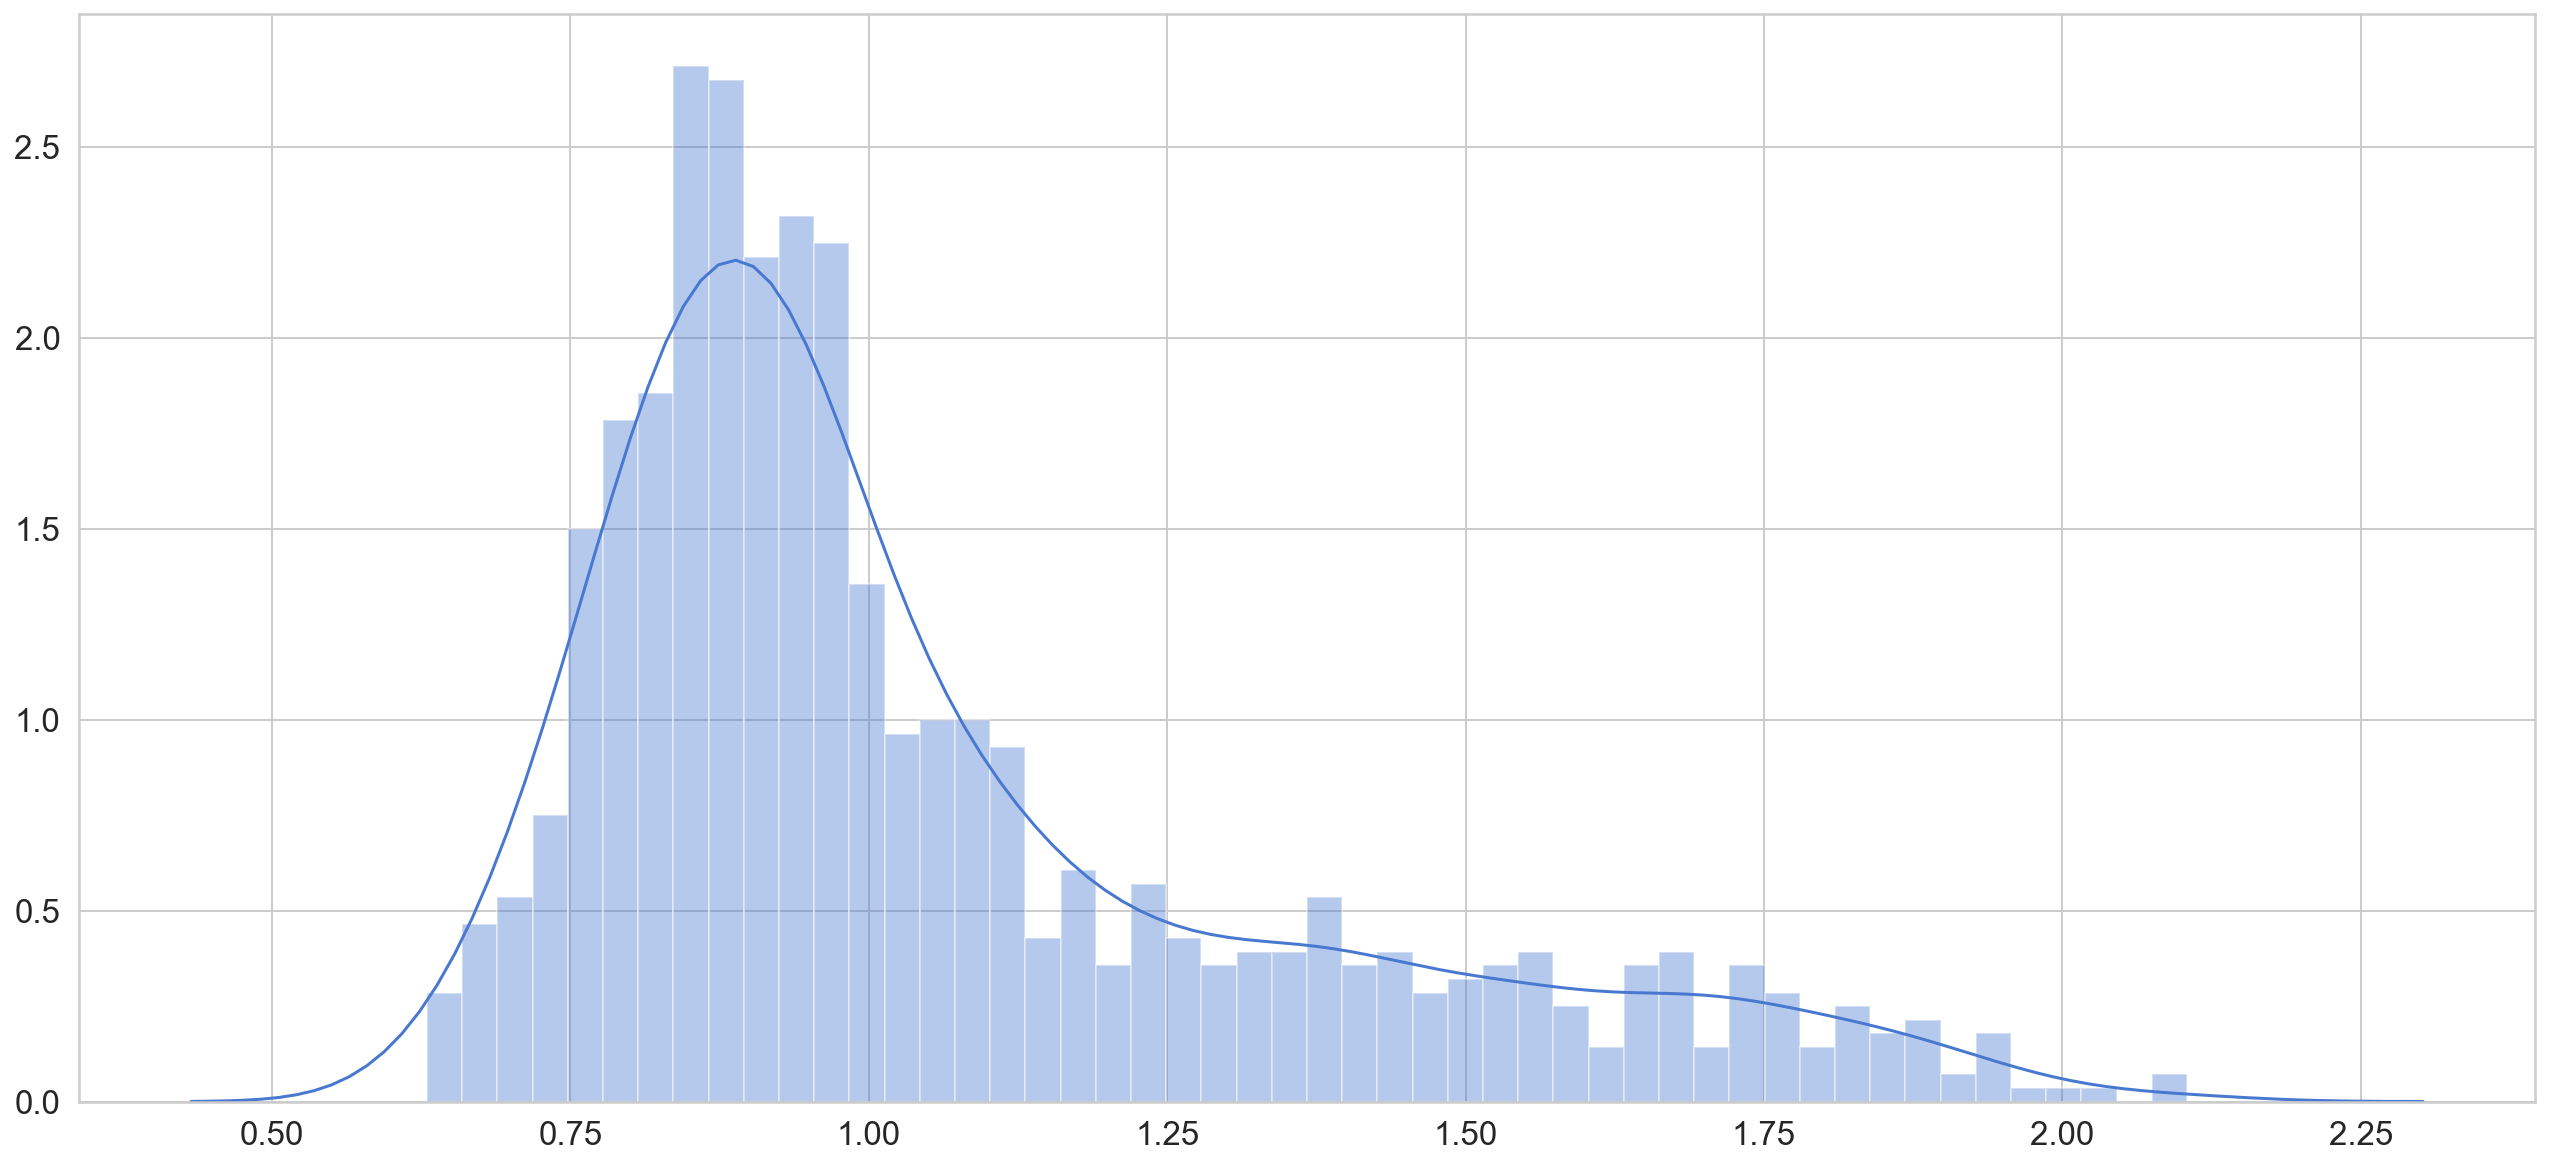

In [56]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [57]:
X_test_pred = model.predict(X_test)
X_test_score = model.s

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [86]:
X_test_pred.shape

(650, 50, 1)

In [58]:
THRESHOLD = 2.2

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['data'] = test[TIME_STEPS:].data

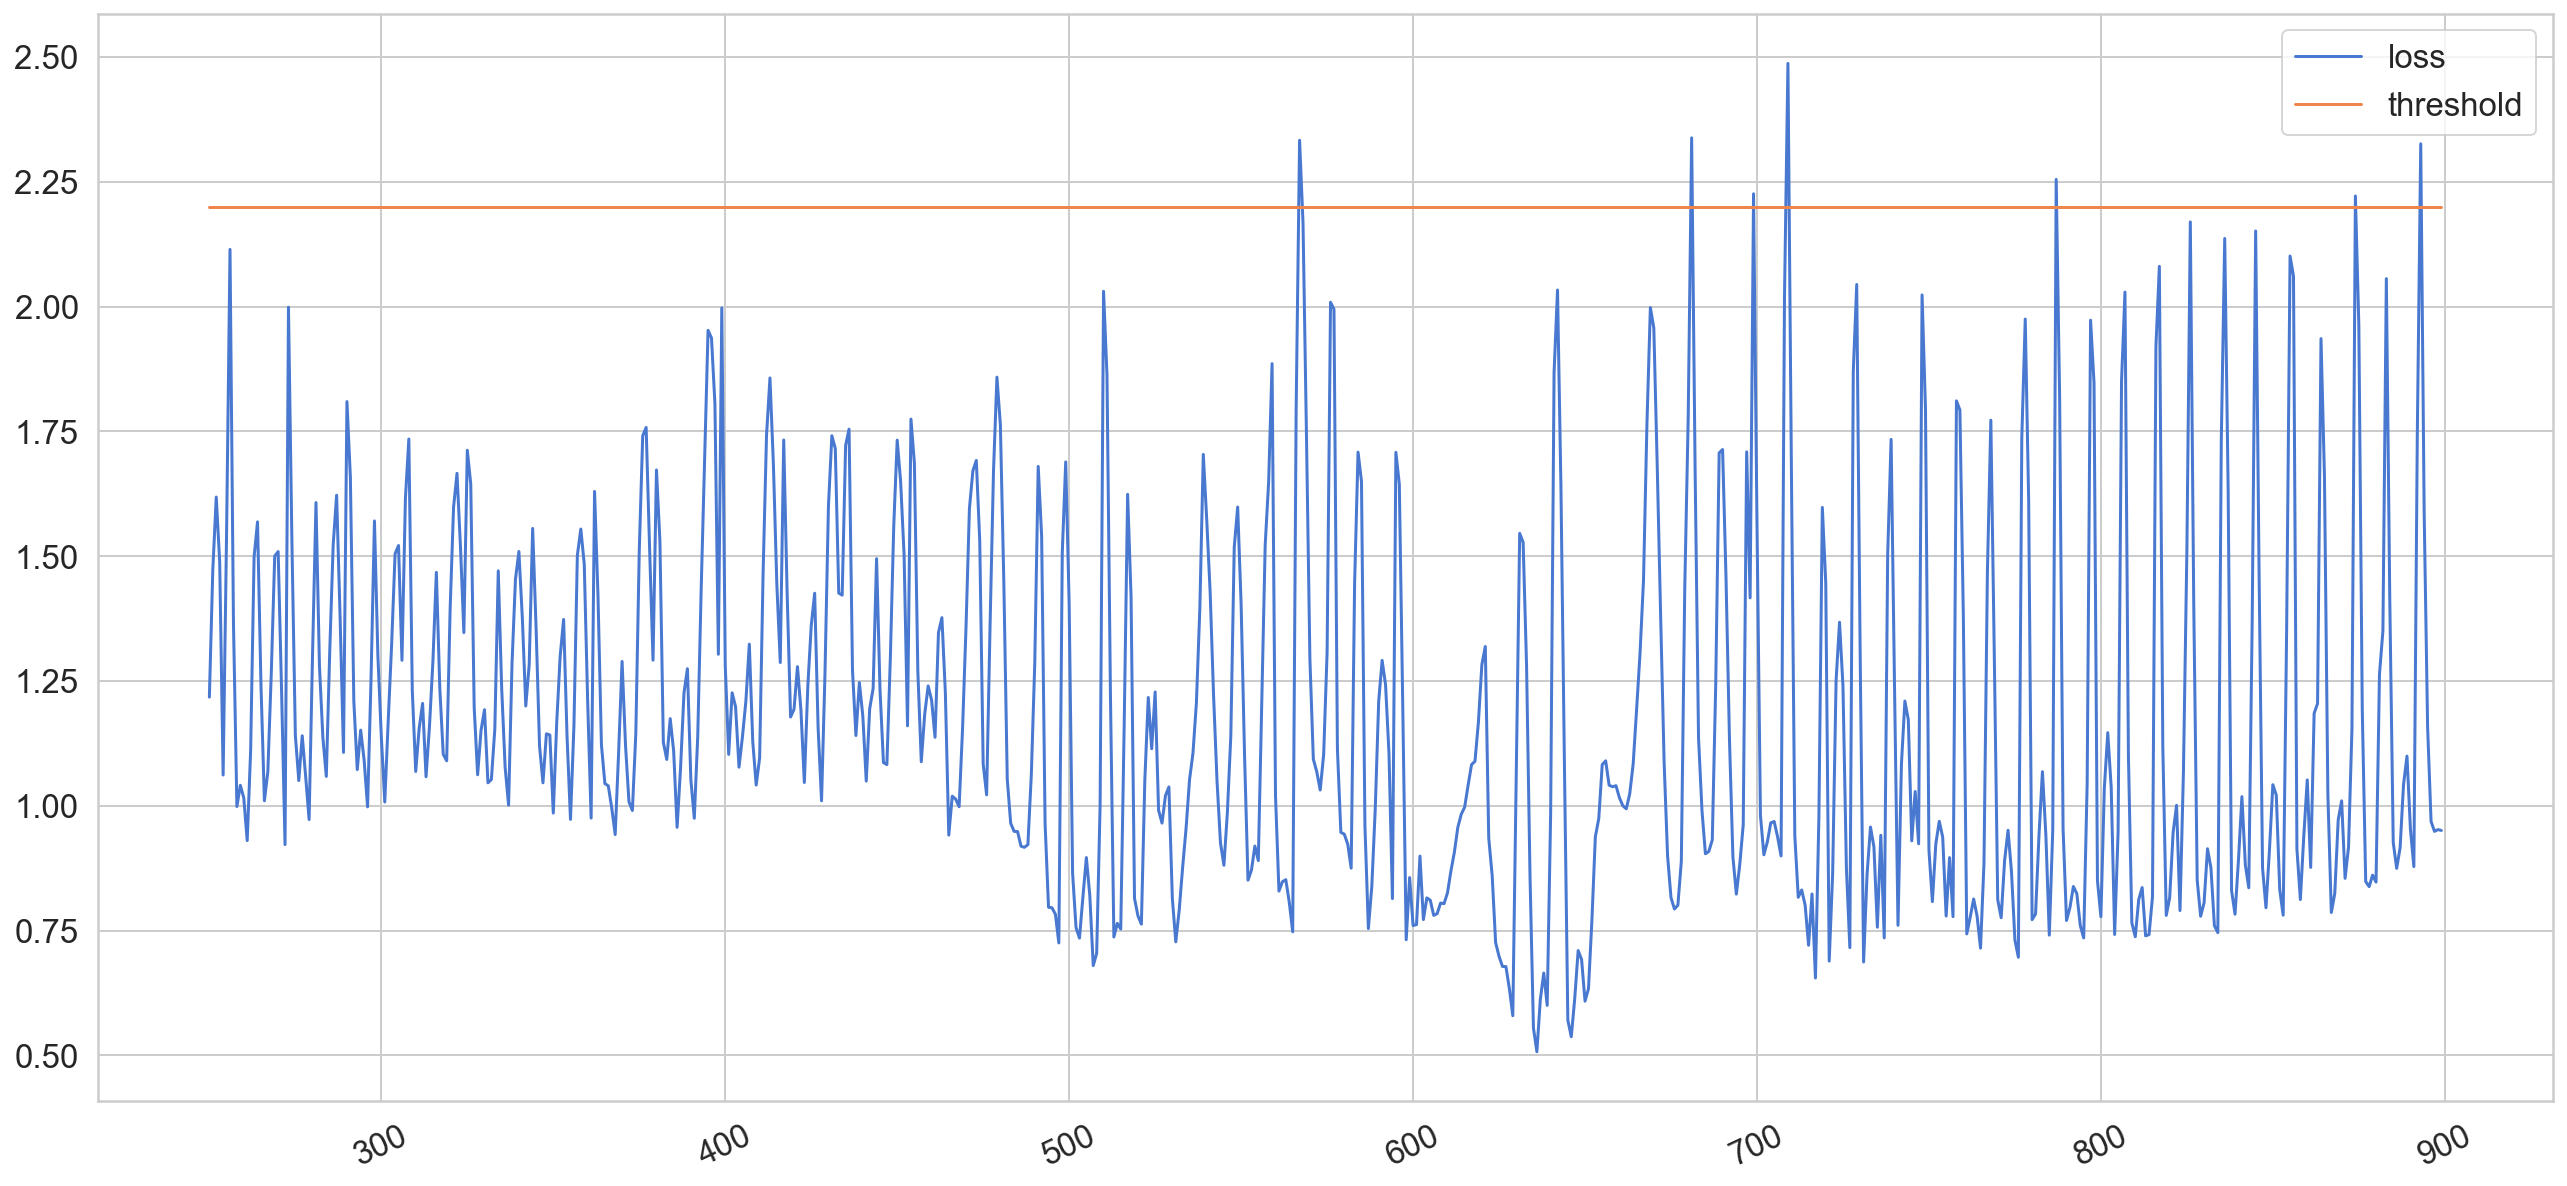

In [59]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [60]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,data
567,2.333366,2.2,True,1.364900
681,2.338186,2.2,True,-0.131762
699,2.226042,2.2,True,0.843199
709,2.487329,2.2,True,1.771672
787,2.254897,2.2,True,0.980081


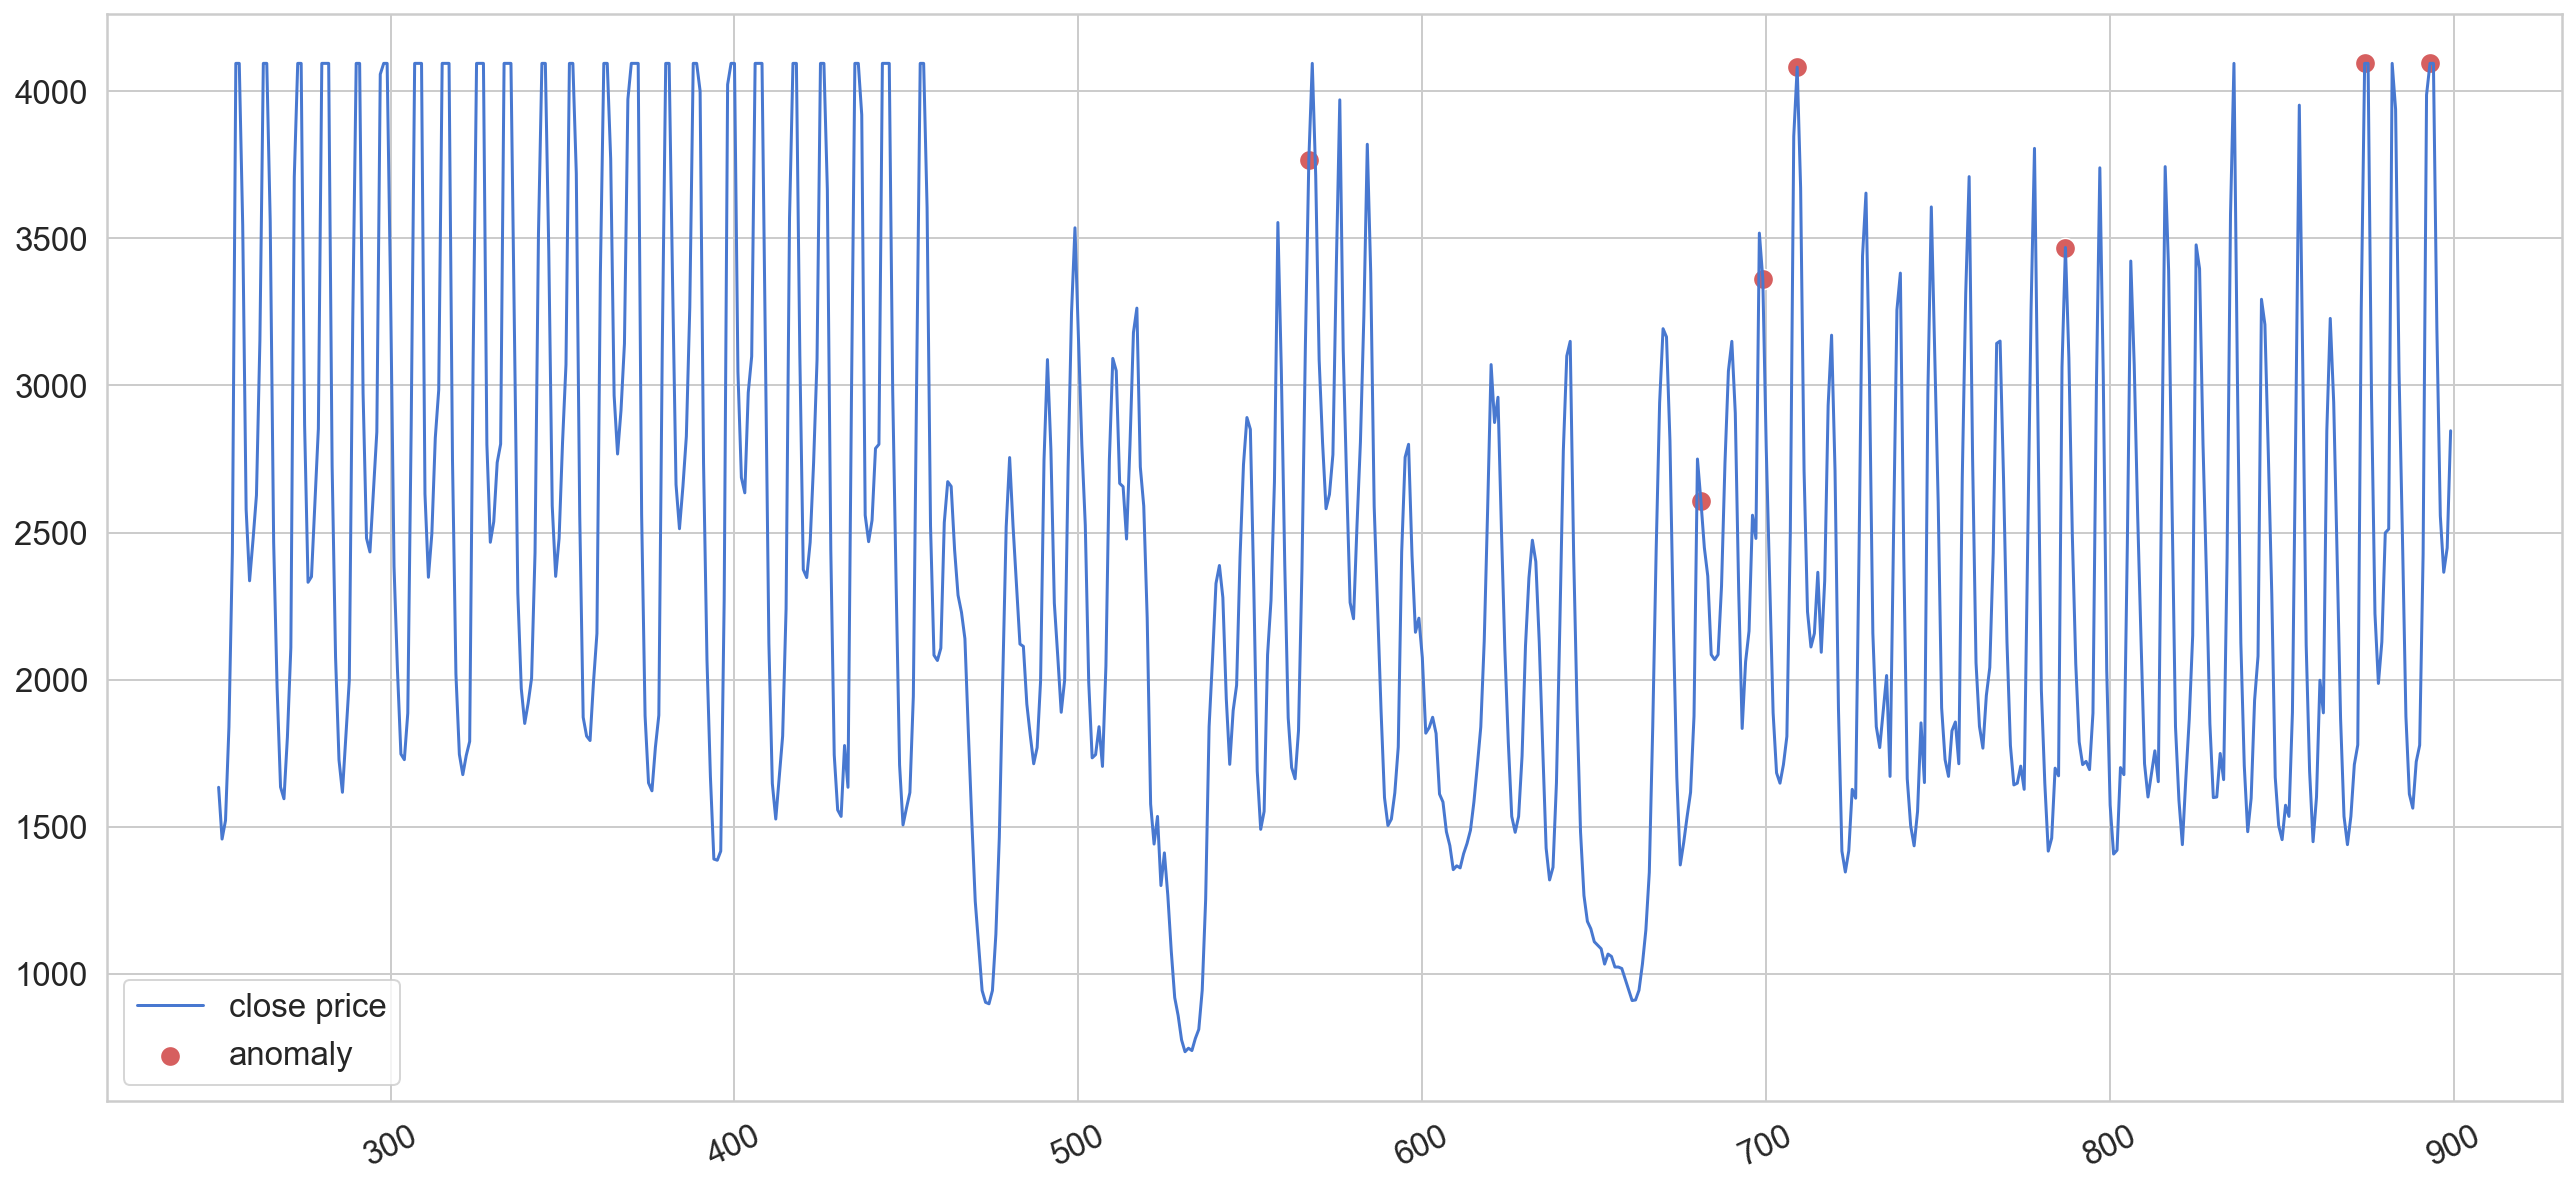

In [62]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].data), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.data),
  color=sns.color_palette()[3],
  s=102,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

ValueError: x and y can be no greater than 2-D, but have shapes (650,) and (650, 50, 1)

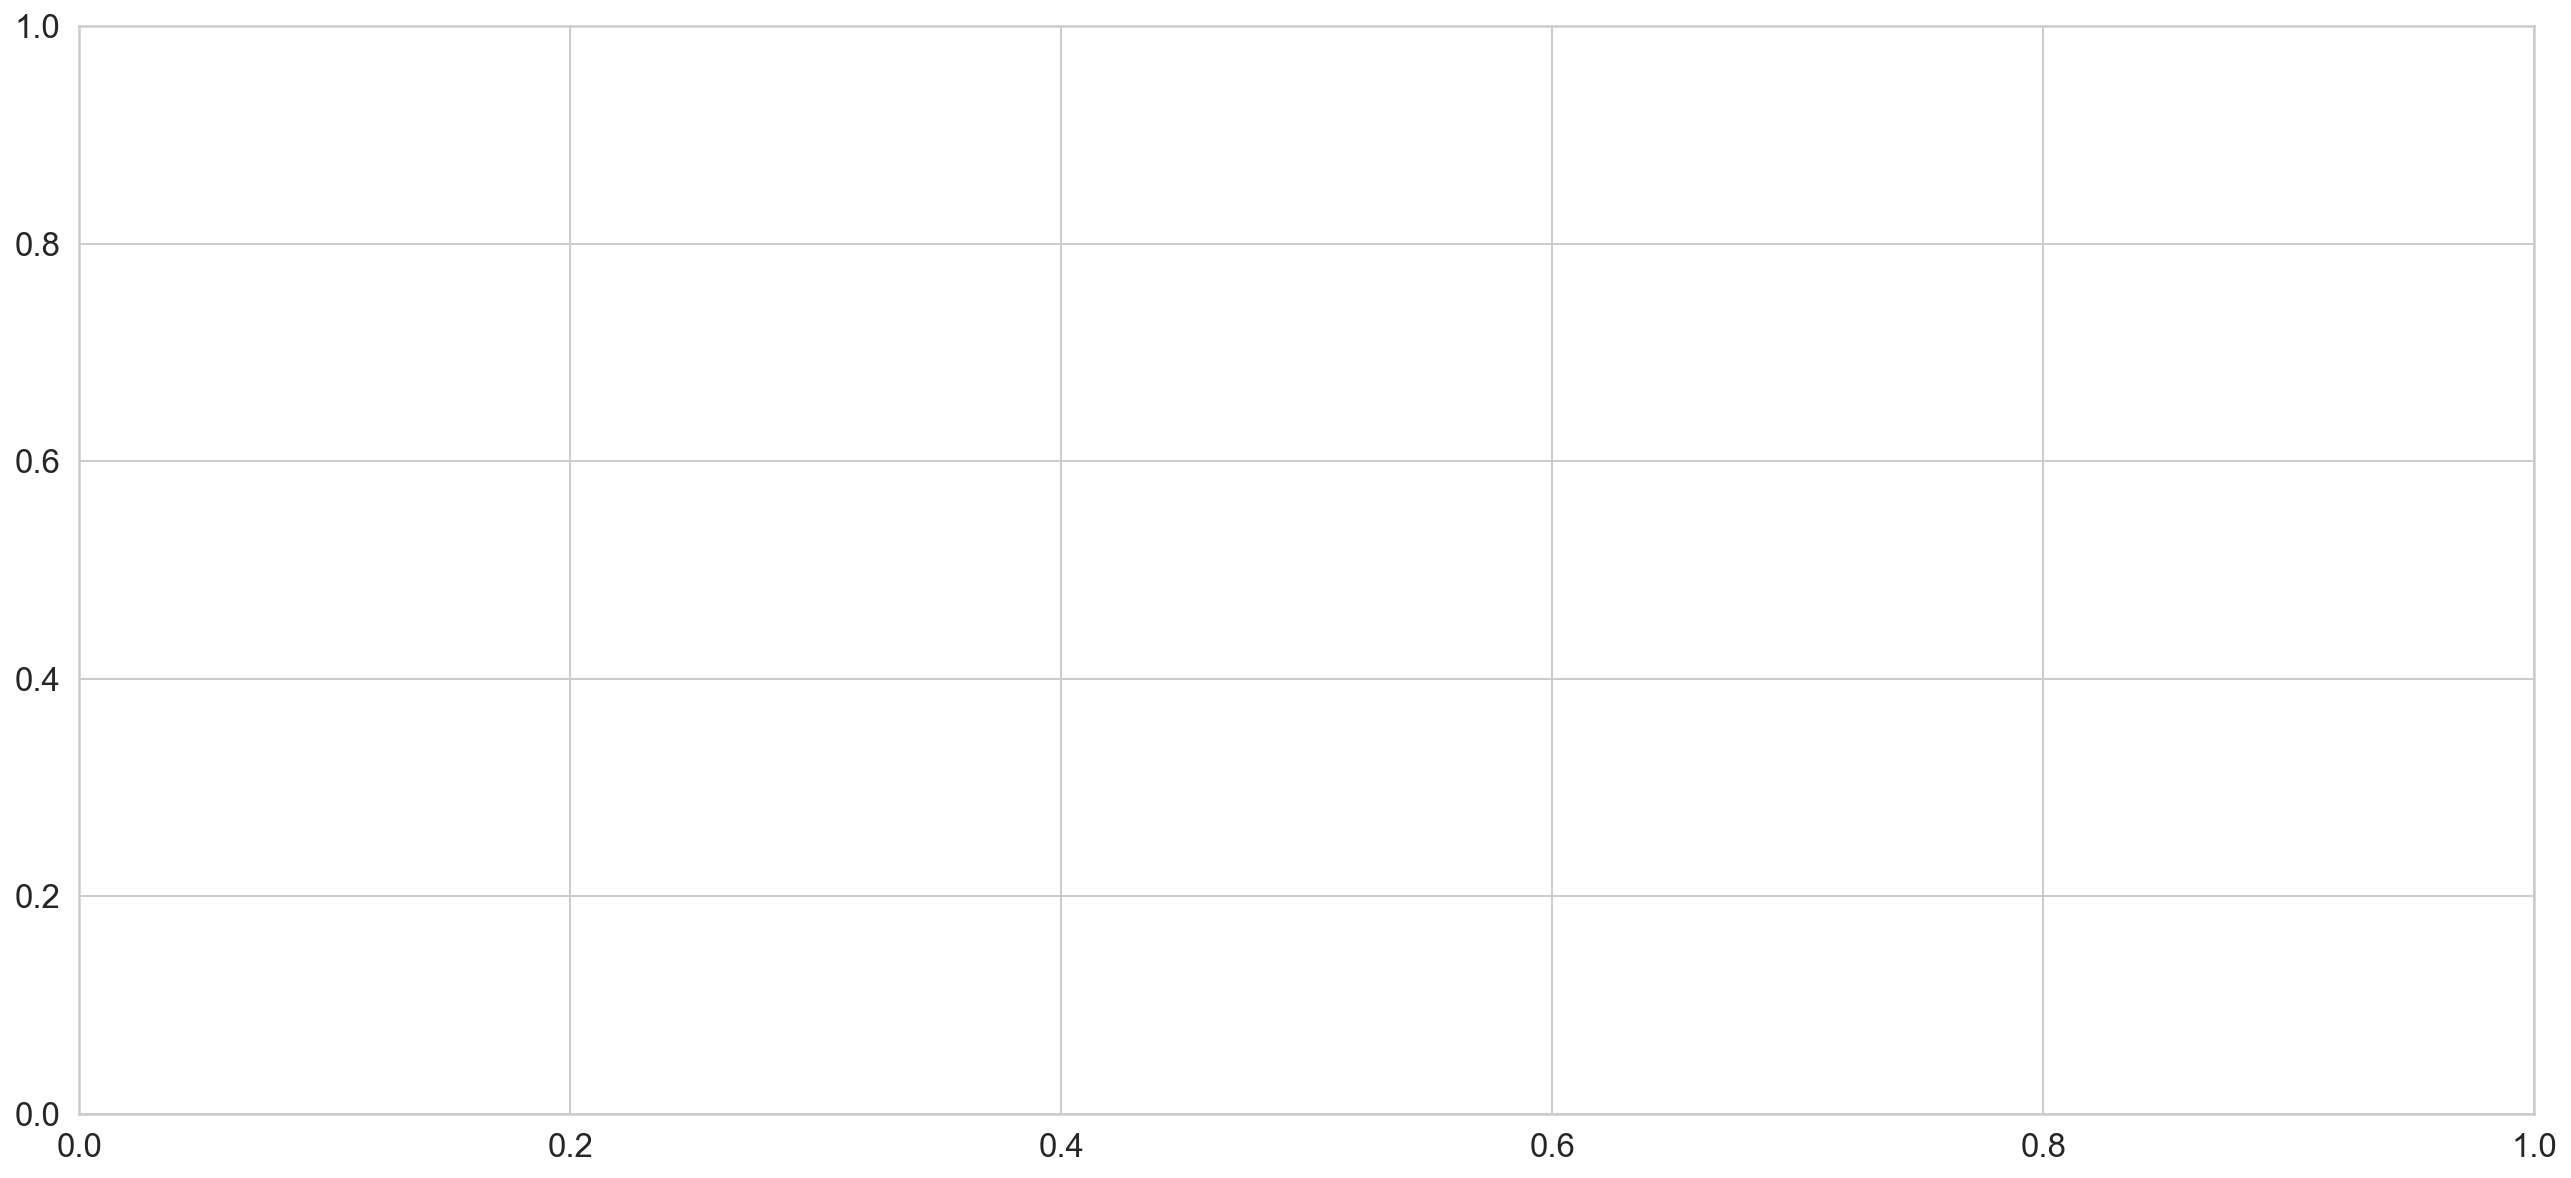

In [84]:
plt.plot(X_test_pred, label='close price')
plt.legend();

https://www.youtube.com/watch?v=xaIA83x5Icg

https://www.curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/

## sinの関数を予測

https://medium.com/@krzysztofbalka/training-keras-lstm-to-generate-sine-function-2e3c0ca42c3b

## ノイズデータ

https://www.machinecurve.com/index.php/2019/12/19/creating-a-signal-noise-removal-autoencoder-with-keras/